# QuOperator in TensorCircuit

## Overview

`tensorcircuit.quantum.QuOperator`, `tensorcircuit.quantum.QuVector` and `tensorcircuit.quantum.QuAdjointVector` are classes adopted from TensorNetwork package.
They behave like a matrix/vector (column or row) when interacting with other ingredients while the inner structure is maintained by the tensornetwork for efficiency and compactness.

``QuOperator``/``QuVector`` can represent any MPO/MPS, but they can express more flexible tensor network structures.
Indeed, any tensor network with two sets of dangling edges of the same dimension can be treated as ``QuOperator``. ``QuVector`` is even more flexible since we can treat all dangling edges as the vector dimension.

In this note, we will show how such tensor network backend matrix/vector data structure is more efficient and compact in several scenarios and how these structures integrated with quantum circuit simulation tasks seamlessly as different circuit ingredients.

## Setup

In [1]:
import numpy as np
import tensornetwork as tn
import tensorcircuit as tc

print(tc.__version__)

0.0.220413


## Introduction to QuOperator/QuVector

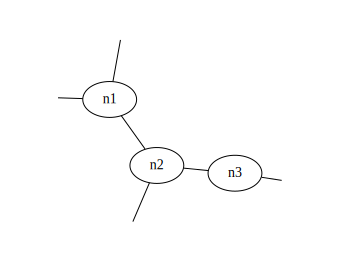

In [2]:
n1 = tn.Node(np.ones([2, 2, 2]), name="n1")
n2 = tn.Node(np.ones([2, 2, 2]), name="n2")
n3 = tn.Node(np.ones([2, 2]), name="n3")
# name is only for debug and visualization, can be omitted
n1[2] ^ n2[2]
n2[1] ^ n3[0]

# initialize a QuOperator by giving two sets of dangling edges for row and col index
matrix = tc.quantum.QuOperator(out_edges=[n1[0], n2[0]], in_edges=[n1[1], n3[1]])
tn.to_graphviz(matrix.nodes)

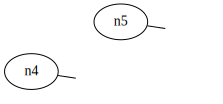

In [3]:
n4 = tn.Node(np.ones([2]), name="n4")
n5 = tn.Node(np.ones([2]), name="n5")

# initialize a QuVector by giving dangling edges
vector = tc.quantum.QuVector([n4[0], n5[0]])
tn.to_graphviz(vector.nodes)

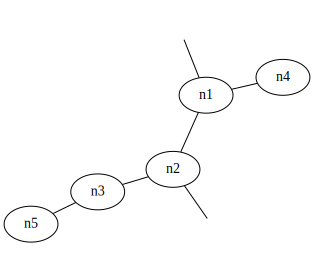

In [4]:
nvector = matrix @ vector
tn.to_graphviz(nvector.nodes)
# nvector has two dangling edges

In [5]:
assert type(nvector) == tc.quantum.QuVector

In [6]:
nvector.eval_matrix()

array([[16.],
       [16.],
       [16.],
       [16.]])

In [7]:
# or we can have more matrix/vector like operation
(3 * nvector).eval_matrix()

array([[48.],
       [48.],
       [48.],
       [48.]])

In [8]:
matrix.partial_trace([0]).eval_matrix()

array([[8., 8.],
       [8., 8.]])

Note how in this example, ``matrix`` is not a typical MPO but still can be expressed as ``QuOperator``. Indeed, any tensor network with two sets of dangling edges of the same dimension can be treated as ``QuOperator``. ``QuVector`` is even more flexible since we can treat all dangling edges as the vector dimension.

Also, note how ``^`` is overloaded as ``tn.connect`` to connect edges between different nodes in TensorNetwork. And indexing the node gives the edges of the node, eg. ``n1[0]`` means the first edge of node ``n1``.

The convention to define the ``QuOperator`` is firstly giving ``out_edges`` (left index or row index of the matrix) and then giving ``in_edges`` (right index or column index of the matrix). The edges list contains edge objects from the TensorNetwork library.

Such QuOperator/QuVector abstraction support various calculations only possible on matrix/vectors, such as matmul (``@``), adjoint (``.adjoint()``), scalar multiplication (``*``), tensor product (``|``), and partial trace (``.partial_trace(subsystems_to_trace_out)``).
To extract the matrix information of these objects, we can use ``.eval()`` or ``.eval_matrix()``, the former keeps the shape information of the tensor network while the latter gives the matrix representation with shape rank 2.

The workflow here can also be summarized and visualized as ![](../statics/quop.png)

## QuVector as input state for the circuit

Since ``QuVector`` behaves like a real vector with more compact representation, we can feed the circuit input states in the form of ``QuVector`` instead of plain numpy array vector.

In [9]:
# This examples shows how we feed a |111> state into the circuit

n = 3
nodes = [tc.gates.Gate(np.array([0.0, 1.0])) for _ in range(n)]
mps = tc.quantum.QuVector([nd[0] for nd in nodes])
c = tc.Circuit(n, mps_inputs=mps)
c.x(0)
c.expectation_ps(z=[0])

array(1.+0.j)

## QuVector as output state of the circuit

The tensor network representation of the circuit can be regarded as a ``QuVector``, namely we can manipulate the circuit as a vector before the real contraction. This is also how we do circuit composition internally. 

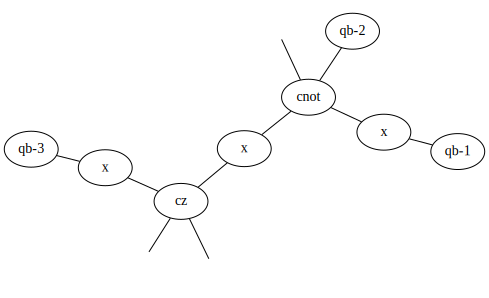

In [10]:
# Circuit composition example

n = 3
c1 = tc.Circuit(n)
c1.X(0)
c1.cnot(0, 1)
mps = c1.quvector()
c2 = tc.Circuit(n, mps_inputs=mps)
c2.X(2)
c2.X(1)
c2.cz(1, 2)
c2.expectation_ps(z=[1])
tn.to_graphviz(c2.get_quvector().nodes)

In [11]:
# The above is the core internal mechanism for circuit composition
# And the user API is as follows

n = 3
c1 = tc.Circuit(n)
c1.X(0)
c1.cnot(0, 1)

c2 = tc.Circuit(n)
c2.X(2)
c2.X(1)
c2.cz(1, 2)
c1.append(c2)

c1.draw()

┌───┐             
q_0: ┤ X ├──■──────────
     └───┘┌─┴─┐┌───┐   
q_1: ─────┤ X ├┤ X ├─■─
     ┌───┐└───┘└───┘ │ 
q_2: ┤ X ├───────────■─
     └───┘

## QuOperator as operator to be evaluated on the circuit

The matrix to be evaluated over the output state of the circuit can also be represented by QuOperator, which is very powerful and efficient for some lattic model Hamiltonian.

In [12]:
# Here we show a simplest model, where we measure <Z_0Z_1>

z0, z1 = tc.gates.z(), tc.gates.z()
mpo = tc.quantum.QuOperator([z0[0], z1[0]], [z0[1], z1[1]])
c = tc.Circuit(2)
c.X(0)
tc.templates.measurements.mpo_expectation(c, mpo)
# the mpo expectation API

-1.0

## QuOperator as the quantum gate applied on the circuit

Since quantum gates are also unitary matrix, we can also use QuOperator for quantum gates. In some cases, QuOperator representation for quantum gates is much more compact, such as in multi control gate case, where the bond dimension can be reduced to 2 for neighboring qubits.

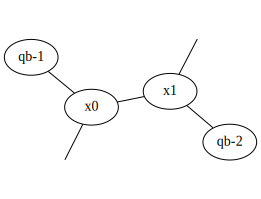

In [13]:
# The general mpo gate API is just ``Circuit.mpo()``

x0, x1 = tc.gates.Gate(np.ones([2, 2, 3]), name="x0"), tc.gates.Gate(
    np.ones([2, 2, 3]), name="x1"
)
x0[2] ^ x1[2]
mpo = tc.quantum.QuOperator([x0[0], x1[0]], [x0[1], x1[1]])
c = tc.Circuit(2)
c.mpo(0, 1, mpo=mpo)
tn.to_graphviz(c._nodes)

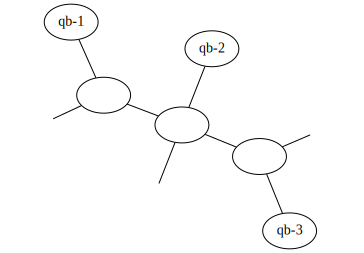

In [14]:
# And the built-in multi control gate is used as follows:

c = tc.Circuit(3)
c.multicontrol(0, 1, 2, ctrl=[0, 1], unitary=tc.gates.x())
tn.to_graphviz(c._nodes)

In [15]:
c.to_qir()[0]["gate"].nodes

{Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j]]],
 
 
        [[[0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j]],
 
         [[0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j]]]], dtype=complex64),
 edges : 
 [
 Edge('__unnamed_node__'[2] -> '__unnamed_node__'[0] )
 , 
 Edge(Dangling Edge)[1] 
 , 
 Edge(Dangling Edge)[2] 
 , 
 Edge('__unnamed_node__'[3] -> '__unnamed_node__'[0] )
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]],
 
        [[1.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]]], dtype=complex64),
 edges : 
 [
 Edge('__unnamed_node__'[3] -> '__unnamed_node__'[0] )
 , 
 Edge(Dangling Edge)[1] 
 , 
 Edge(Dangling Edge)[2] 
 ] 
 ),
 Node
 (
 name : '__unnamed_node__',
 tensor : 
 array([[[1.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],
 
        [[0.+0.j, 0.+0.j],
         [0.+0.j, 1.+0.j]]], dtype=complex64),
 edges : 


In [16]:
c.to_qir()[0]["gate"].eval_matrix()

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]],
      dtype=complex64)